[View in Colaboratory](https://colab.research.google.com/github/gresash/ML4AAD-Lab-SS2018/blob/master/Exercise_1_4.ipynb)

# Using SMAC to optimize hyperparameters of SVM

* Installation of SMAC
* Defintion of function to be optimized (SVM on Iris Dataset)
* Definition of SVM's configspace
* Definition of SMAC's scenario
* Running SMAC

## Installation of SMAC and its Dependencies

In [42]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0, "./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development


Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-vab5oaa1
  Running setup.py bdist_wheel for smac ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-0jn7164e/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Optimize RF RMSE performance on Boston Dataset

In [0]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt


def get_history(smac):
    # get runhistory, all runs ever evaluated by smac
    runhistory = smac.get_runhistory()

    # extract x value and corresponding y value
    cost = []
    for entry in runhistory.data:  # iterate over data because it is an OrderedDict
        config_id = entry.config_id  # look up config id
        config = runhistory.ids_config[config_id]  # look up config
        z_ = runhistory.get_cost(config)  # get cost
        cost.append(z_)
    cost = np.array(cost)
    return cost


def plot_log_scale(y_smac, maxfun, label, color):
    x = np.linspace(0, maxfun, num=maxfun)
    # Plotting
    ax = plt.subplot(111)

    plt.xlabel('#evaluations')
    plt.ylabel('Loss')

    # let's plot only the best function value at each time step
    y_median = np.zeros(maxfun)
    y_25th = np.zeros(maxfun)
    y_75th = np.zeros(maxfun)
    for id in range(maxfun):
        y_median[id] = np.percentile(y_smac[:id+1], 50)
        y_25th[id] = np.percentile(y_smac[:id+1], 25)
        y_75th[id] = np.percentile(y_smac[:id+1], 75)

    plt.plot(y_median, 'o', color=color)
    ax.step(y_median, 'k', where="post", label=label, color=color)
    ax.set_xscale("log")
    plt.fill_between(x, y_25th, y_75th, alpha=0.5, color=color, step='pre')
    plt.show()

iris = load_iris()


def svc_from_cfg(cfg):
    """ Creates a SVM based on a configuration and evaluates it on the
    iris-dataset using cross-validation.

    Parameters:
    -----------
    cfg: Configuration (ConfigSpace.ConfigurationSpace.Configuration)
        Configuration containing the parameters.
    Returns:
    --------
    A crossvalidated mean score for the svm on the loaded data-set.
    """
    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    cfg = {k: cfg[k] for k in cfg if cfg[k]}
    # We translate boolean values
    cfg["shrinking"] = True if cfg["shrinking"] == "true" else False
    # And for gamma, we set it to a fixed value or to "auto" (if used)
    if "gamma" in cfg:
        cfg["gamma"] = cfg["gamma_value"] if cfg["gamma"] == "value" else "auto"
        cfg.pop("gamma_value", None)  # Remove "gamma_value"
    clf = SVC(**cfg, random_state=42)
    scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring=make_scorer(accuracy_score))
    return np.mean(scores)


## Define Configuration Space

In [44]:
from smac.configspace import ConfigurationSpace
from ConfigSpace.conditions import InCondition
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter

cs = ConfigurationSpace()

shrinking = CategoricalHyperparameter("shrinking", ["true", "false"], default_value="true")
kernel = CategoricalHyperparameter("kernel", ["linear", "poly", "rbf", "sigmoid"], default_value="poly")
degree = UniformIntegerHyperparameter("degree", 1, 5, default_value=3)
gamma = CategoricalHyperparameter("gamma", ["auto", "value"], default_value="value")
gamma_value = UniformFloatHyperparameter("gamma_value", 0.001, 8, default_value=1)
coef0 = UniformFloatHyperparameter("coef0", 0.0, 10.0, default_value=0.0)
c = UniformFloatHyperparameter("C", 0.001, 1000.0, default_value=1.0)

cs.add_hyperparameters([c, kernel, degree, shrinking, gamma, gamma_value, coef0])
use_degree = InCondition(child=degree, parent=kernel, values=["poly"])
use_gamma_value = InCondition(child=gamma_value, parent=gamma, values=["value"])
use_gamma = InCondition(child=gamma, parent=kernel, values=["poly", "rbf", "sigmoid"])
use_coef0 = InCondition(child=coef0, parent=kernel, values=["poly", "sigmoid"])
cs.add_conditions([use_degree, use_gamma_value, use_gamma, use_coef0])


[degree | kernel in {'poly'},
 gamma_value | gamma in {'value'},
 gamma | kernel in {'poly', 'rbf', 'sigmoid'},
 coef0 | kernel in {'poly', 'sigmoid'}]

## Define Scenario

In [0]:
from smac.scenario.scenario import Scenario

scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternative runtime)
                    "runcount-limit": 200,  # time for running SMAC
                     "cs": cs,  # configuration space
                     "deterministic": "true",
                     })


## Run SMAC

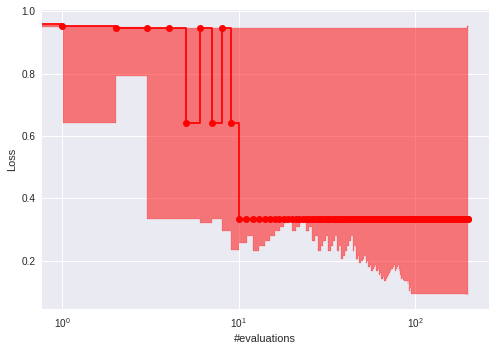

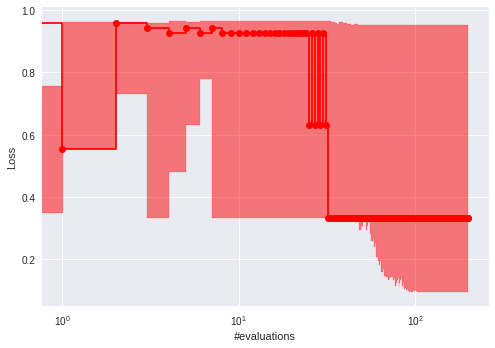

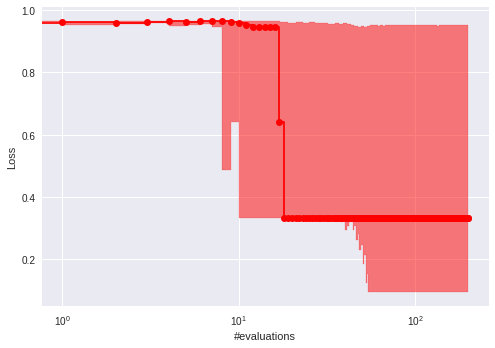

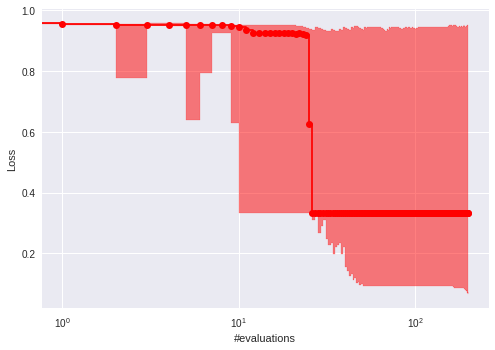

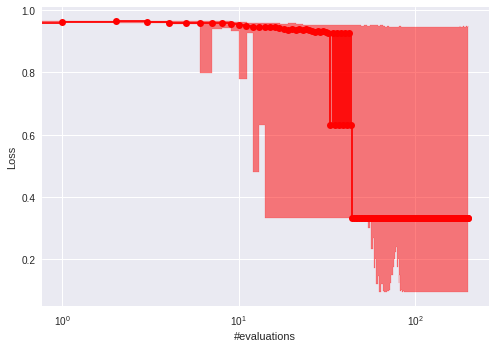

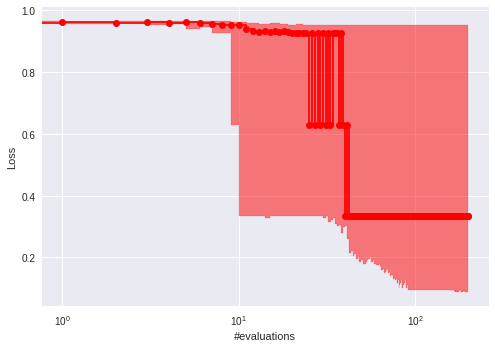

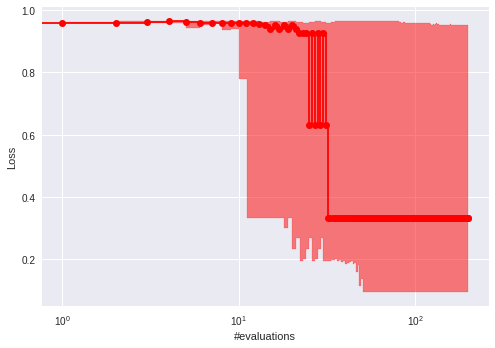

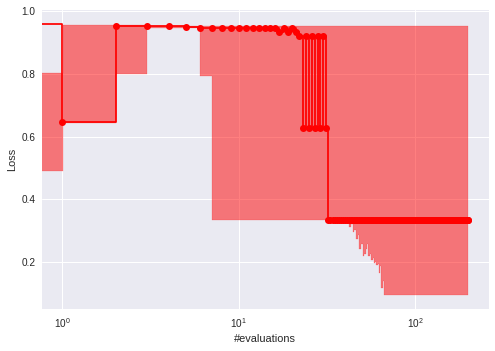

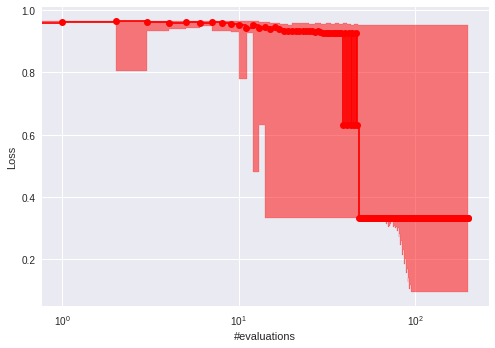

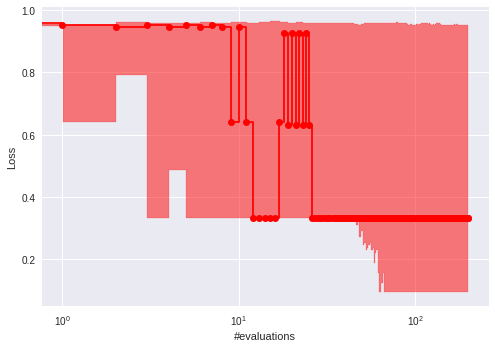

In [47]:
from smac.facade.smac_facade import SMAC
for i in np.random.randint(10000, size=10):
    smac = SMAC(scenario=scenario, rng=np.random.RandomState(i),
                tae_runner=svc_from_cfg)

    incumbent = smac.optimize()
    cost = get_history(smac)
    plot_log_scale(cost, 200, "SVM", "red")
